# Deep Deterministic Policy Gradient (DDPG)

We introduce a python code for Deep Deterministic Policy Gradient (DDPG). Compared to methods using stochastic policy, where from given state $s$ the policy is defined as a probability distribution $\pi(\cdot|s)$ and the algorithm chooses one of the action based on that distribution, deterministic policy $\mu(s)$ provides a specific value from the given state $s$, hence called **deterministic**.  The paper can be found [here](https://arxiv.org/abs/1509.02971), and the code is modified from [this](https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b) and [this](https://github.com/sfujim/TD3/blob/master/OurDDPG.py) websites.

In [3]:
import sys
import gym
import copy
import time

import torch
import torch.autograd
import torch.nn            as nn
import torch.nn.functional as F 
import torch.optim         as optim
import numpy               as np
import matplotlib.pyplot   as plt
import moviepy.editor      as mpy

# Check whether GPU computation (i.e., CUDA) is available.
device = torch.device( "cuda" if torch.cuda.is_available( ) else "cpu" )


# Actor and Critic Networks

For the DDPG algorithm, we split the Actor and Critic networks. Both networks used [ADAM optimizer](https://arxiv.org/pdf/1412.6980.pdf). 

## Actor
The actor network also has four layers, and it gets state vector as input and returns an action $a=\mu(s)$.
The learning rate of the [ADAM optimizer](https://arxiv.org/pdf/1412.6980.pdf) is $10^{-4}$, which is identical to the [original paper](https://arxiv.org/pdf/1509.02971.pdf). [Details in Supplementary Material, Section 7 - Experiment Details](https://arxiv.org/pdf/1509.02971.pdf). 
The output of the actor network is ranged from $-1$ to $+1$, hence normalization or rescalaing the output to the actual action range of the environment is later required.

## Critic 
The critic has four layers, and the critic learns the Q-function, $Q(s,a)$, hence the input is a concatenation of state and action, with a scalar output.
We have slightly modified the neural network architecture of the [original paper](https://arxiv.org/pdf/1509.02971.pdf). For the [original paper](https://arxiv.org/pdf/1509.02971.pdf), actions $a_t$ were not included until the 2nd hidden layer of the Critic Network. [Details in Supplementary Material, Section 7 - Experiment Details](https://arxiv.org/pdf/1509.02971.pdf).
However for us, we simply concatenate the state and action tuples and feedfoward that to the 1st layer of the Critic Network. 
The learning rate of the [ADAM optimizer](https://arxiv.org/pdf/1412.6980.pdf) is $10^{-3}$, which is identical to the [original paper](https://arxiv.org/pdf/1509.02971.pdf).


In [4]:

class Actor( nn.Module ):
    """
        Learning the a = mu(s) mapping, which is a deterministic function.
    """
    def __init__( self, n_state: int, n_action: int, n_hidden: int = 256, max_action: float = 1.0 ):

        # Class inheritance. 
        super( Actor, self ).__init__( )

        # Save the maximum action value 
        assert max_action >= 0
        self.max_action = max_action

        # First Layer, changes array  with size N x ( n_state  ) to N x ( n_hidden )
        self.l1 = nn.Linear(  n_state, n_hidden )

        # Second Layer, changes array with size N x ( n_hidden ) to N x ( n_hidden )
        self.l2 = nn.Linear( n_hidden, n_hidden )

        # Third Layer, changes array  with size N x ( n_hidden ) to N x ( n_action )
        self.l3 = nn.Linear( n_hidden, n_action )
        
    def forward( self, state ):
        
        # Applying Rectified Linear Unit (ReLU) to x
        x = F.relu( self.l1( state ) )

        # Applying Rectified Linear Unit (ReLU) to x
        x = F.relu( self.l2( x ) )

        # Applying to tanh, which ranges the value from -1 to +1
        x = torch.tanh( self.l3( x ) ) 

        # Since the x value is from -1 to +1, we change the range to -max_action to +max_action.
        return x * self.max_action

class Critic( nn.Module ):
    """
        Learning the Q(s,a) function, which is the "Quality" function. Hence, input is a concatenation of state, action and the output is a scalar. 
    """
    def __init__( self, n_state, n_action, n_hidden = 256 ):

        # Class inheritance. 
        super( Critic, self ).__init__()

        # First Layer, changes array with size N x ( n_state + n_action ) to N x ( n_hidden )
        self.l1 = nn.Linear( n_state + n_action, n_hidden )

        # Second Layer, changes array with size N x ( n_hidden ) to N x ( n_hidden )
        self.l2 = nn.Linear( n_hidden, n_hidden )

        # Third Layer, changes array with size N x ( n_hidden ) to N x ( 1 ), since Q is a scalar function. 
        self.l3 = nn.Linear( n_hidden, 1 )

    
    def forward( self, state, action ):

        # Concatenation of state and action vector.
        # The state  is assumed to be a 2D array with size N x n_s, where N is the number of samples
        # The action is assumed to be a 2D array with size N x n_a, where N is the number of samples
        # As a result of torch.cat( [ state, action ] along axis 1, ), we have size N x ( n_s + n_a ), and the dim = 0 must have the same size
        x = torch.cat( [ state, action ], dim = 1 )

        # Applying Rectified Linear Unit (ReLU) to x
        x = F.relu( self.l1( x ) )

        # Applying Rectified Linear Unit (ReLU) to x
        x = F.relu( self.l2( x ) )

        # A simple Ax + b combination 
        x = self.l3( x )

        # The output is a N x 1 array. 
        return x



# Replay Buffer
As in Deep Q-Network (DQN), we construct a replay buffer. As mentioned in [this paper](https://arxiv.org/abs/1509.02971), optimization algorithms assume that the samples are independently and identically distributed, and the replay buffer addresses that problem. Replay buffer is simply a collection of state-action-reward-next state pairs, $(S_t, A_t, R_{t+1}, S_{t+1})$. 
The code is borrowed from [this repository](https://github.com/sfujim/TD3/blob/master/utils.py).

In [5]:
class ReplayBuffer( object ):

    def __init__( self, n_state, n_action, max_size = 100000 ):

        # Save the dimension of state, dimension of action and the maximum size of the replay buffer
        self.n_state  = n_state
        self.n_action = n_action
        self.max_size = max_size

        # Defining the current size of the replay buffer, just to make the sampling easy. 
        self.current_size = 0

        # Defining the Index Pointer (ptr) of the replaybuffer. 
        # This is required for "adding" the experiences on the replaybuffer. 
        self.idx_ptr      = 0

        # Defining the 2D arrays of the ReplayBuffer
        # 2D array definition is necessary to forward the Neural Network
        self.states      = np.zeros( ( max_size, n_state   ) )
        self.actions     = np.zeros( ( max_size, n_action  ) )
        self.rewards     = np.zeros( ( max_size, 1         ) )
        self.next_states = np.zeros( ( max_size, n_state   ) )
        self.is_done     = np.zeros( ( max_size, 1         ) )


    def add( self, state, action, reward, next_state, is_done ):
        """
            Adding a state-action-reward-next_state pair into the ReplayBuffer. 
        """

        self.states[      self.idx_ptr ] = state
        self.actions[     self.idx_ptr ] = action
        self.rewards[     self.idx_ptr ] = reward
        self.next_states[ self.idx_ptr ] = next_state
        self.is_done[     self.idx_ptr ] = is_done

        # Update our index pointer. Note that the "oldest" experiences are overwritten.
        self.idx_ptr = ( self.idx_ptr + 1 ) % self.max_size

        # Update the current size of the replay buffer
        self.current_size = min( self.current_size + 1, self.max_size )

    def sample( self, n_batch_size ):
        """
            Collect "n_batch_size" samples from the replay buffer and return it as a batch.
        """
        idx = np.random.randint( 0, self.current_size, size = n_batch_size )

        # Returning the 2D numpy array as a 2D torch array.

        return ( 
            torch.FloatTensor(      self.states[ idx ]  ).to( device ) ,
            torch.FloatTensor(     self.actions[ idx ]  ).to( device ) , 
            torch.FloatTensor(     self.rewards[ idx ]  ).to( device ) ,
            torch.FloatTensor( self.next_states[ idx ]  ).to( device ) ,
            torch.FloatTensor(     self.is_done[ idx ]  ).to( device )   
        )


    def reset( self ):
        """
            Reset all the replay buffers to zeros
        """
        self.states      = np.zeros( ( self.max_size, self.n_state   ) )
        self.actions     = np.zeros( ( self.max_size, self.n_action  ) )
        self.rewards     = np.zeros( ( self.max_size, 1              ) )
        self.next_states = np.zeros( ( self.max_size, self.n_state   ) )
        self.is_done     = np.zeros( ( self.max_size, 1              ) )


# The Ornstein-Uhlenbeck Process

The Ornstein-Uhlenbeck Process generates noise that is correlated with the previous noise, as to prevent the noise from canceling out or “freezing” the overall dynamics. Adding this noise is mentioned in the [original paper](https://arxiv.org/abs/1509.02971). [Wikipedia](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) provides a thorough explanation of the Ornstein-Uhlenbeck Process. The source code is from [this](https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py). The Ornstein-Uhlenbeck process with an additional drift term can be described as:
$$
    dx_t = \theta (\mu - x_t)dt + \sigma d W_t
$$
where $W_t$ denotes the [Wiener process](https://en.wikipedia.org/wiki/Wiener_process). 


In [6]:

class OUNoise( object ):
    
    def __init__( self, action_space, mu = 0.0, theta = 0.15, max_sigma = 0.3, min_sigma = 0.3, decay_period = 100000 ):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[ 0 ]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset( )
        
    def reset( self ):
        # Caution! The state here is not the "pendulum"'s state, but the "noise" itself. 
        self.state = np.ones( self.action_dim ) * self.mu
        
    def step( self, t = 0 ):
        
        # Call the current noise value. 
        x  = self.state

        # randn returns a sample from the standard (i.e., normal) distribution
        dx = self.theta * ( self.mu - x ) + self.sigma * np.random.randn( self.action_dim )

        # For our case, we simply set the max_sigma and min_sigma the same, hence the sigma value is constant for us
        self.sigma = self.max_sigma - ( self.max_sigma - self.min_sigma ) * min( 1.0, t / self.decay_period )

        # Time-increment. x_{n+1} = x_{n} + dx
        self.state = x + dx

        return self.state
    
    def add_noise2action( self, action, t = 0 ): 
        
        # Calculate the noise with respect to the given time. 
        ou_noise   = self.step( t )

        # Adding ou noise onto the action and then clipping it.
        return np.clip( action + ou_noise, self.low, self.high )


# DDPG Agent
Note that when we develop the actor and critic networks, we also make the copy of those networks, called actor-target and critic-target networks. The details are again, explained in [this paper](https://arxiv.org/abs/1509.02971).

The critic (or value) network is updated similarly as is done in Q-learning, where the target networks are employed. 
The loss function that are used for the policy gradient are defined as follows:
$$
    \text{Loss} = \frac{1}{N} \sum_{i=1}^{N} \big( y_i - Q( s_i, a_i | \theta^{Q}) \big )^2
$$
where $N$ is the sampled batch from the replay buffer. $y_i$ is defined as follows:
$$
    y_i = r_i + \gamma Q'\big( \; s_{i+1}, \; \mu'(s_{i+1} | \theta^{\mu'} ) | \theta^{Q'} \big)
$$
where comma superscript stands for the target network parameters. 

The actor network is updated with the following equation:
$$
    J( \theta ) = \mathbb{E} \big[ Q(s,a)|_{s=s_t, a = \mu(s_t)} \big]
$$

For the target networks, the parameters are "soft" updated with the following equations:
$$
\begin{align*}
    \theta^{Q'}   & \longleftarrow \tau \theta^{Q}   + ( 1 - \tau ) \theta^{Q'}   \\
    \theta^{\mu'} & \longleftarrow \tau \theta^{\mu} + ( 1 - \tau ) \theta^{\mu'} \\
\end{align*}
$$
where $\tau \in [0,1)$ and we should choose a small value (for our example, $\tau=0.01$ )

In [7]:

class DDPGagent( object ):

    def __init__( self, n_state, n_action, max_action = 1., gamma = 0.99, tau = 0.005 ):

        # Actor Network , its target (copy) Network, and the ADAM optimizer.
        self.actor             = Actor( n_state, n_action, max_action = max_action ).to( device )
        self.actor_target      = copy.deepcopy( self.actor )
        self.actor_optimizer   = optim.Adam(  self.actor.parameters( ), lr = 1e-4 )

        # Critic Network, its target (copy) Network, and the ADAM optimizer.
        self.critic            = Critic( n_state, n_action )
        self.critic_target     = copy.deepcopy( self.critic )
        self.critic_optimizer  = optim.Adam(  self.critic.parameters( ), lr = 1e-3 )

        # The discount factor gamma and the soft-update gain tau
        self.gamma = gamma
        self.tau   = tau

        # The maximum action.
        self.max_action = max_action

    
    def get_action( self, state ):

        # Conduct the a = mu(s), where mu is a "deterministic function"
        # Unsqueeze makes an 1 x n_s array of state. 
        state  = torch.from_numpy( state ).float( ).unsqueeze( 0 )

        # Returns an 1 x n_a array of state
        # forward method can be omitted
        action = self.actor( state )

        # Change action from Torch to Numpy.
        # Since n_a is 1 for this case, action is simply an 1x1 array.
        # Hence, flattening the data. 
        action = action.cpu( ).data.numpy( ).flatten( )

        return action
    
    def update( self, replay_buffer, batch_size = 256 ):
        """
            Mini-batch update. 
        """
        # Randomly sample batch_size numbers of S A R S.
        states, actions, rewards, next_states, is_done = replay_buffer.sample( batch_size )

        # ====================================================== #
        # ================ Critic Optimizer Part =============== #
        # ====================================================== #
        # Keep in mind that the original paper first optimizes the Critic network

        # Critic loss 
        Qprime  = self.critic_target( next_states, self.actor_target( next_states ) )
        Qprime  = rewards + ( ( 1. - is_done ) * self.gamma * Qprime ).detach( )
        Q       = self.critic( states,actions )

        critic_loss  = F.mse_loss( Q, Qprime )

        # Update Critic network
        self.critic_optimizer.zero_grad( )
        critic_loss.backward( ) 
        self.critic_optimizer.step( )

        # ====================================================== #
        # ================ Actor Optimizer Part ================ #
        # ====================================================== #
        # Actor loss, it is simply the mean of the Q function 
        # The Q function value Q( s, a ) is actually Q( s, mu( s ) ), hence the Q function is described as the parameters of mu (actor).
        # Since a is a continuous function, we can compute its gradient.   
        actor_loss = - self.critic( states, self.actor( states ) ).mean( )
        
        # Update (Optimize) Actor network
        self.actor_optimizer.zero_grad( )
        actor_loss.backward( )
        self.actor_optimizer.step( )


        # The "soft" update of target networks
        for target_param, param in zip( self.actor_target.parameters( ), self.actor.parameters( ) ):
            target_param.data.copy_( param.data * self.tau + target_param.data * ( 1.0 - self.tau ) )
       
        for target_param, param in zip( self.critic_target.parameters( ), self.critic.parameters( ) ):
            target_param.data.copy_( param.data * self.tau + target_param.data * ( 1.0 - self.tau ) )


    def save( self, filename ):
        
        torch.save( self.critic.state_dict( )           , filename + "_critic"              )
        torch.save( self.critic_optimizer.state_dict( ) , filename + "_critic_optimizer"    )
        
        torch.save( self.actor.state_dict( )            , filename + "_actor"               )
        torch.save( self.actor_optimizer.state_dict( )  , filename + "_actor_optimizer"     )


    def load( self, filename ):

        # Load Critic
        self.critic.load_state_dict(            torch.load( filename + "_critic"           )  )
        self.critic_optimizer.load_state_dict(  torch.load( filename + "_critic_optimizer" )  )
        self.critic_target = copy.deepcopy( self.critic )

        # Load Actor
        self.actor.load_state_dict(             torch.load( filename + "_actor"            )  )
        self.actor_optimizer.load_state_dict(   torch.load( filename + "_actor_optimizer"  )  )
        self.actor_target = copy.deepcopy( self.actor )


In [36]:
# Define instances of the environment, DDPG agent and the OU noise.
env   = gym.make( "Pendulum-v1" ) 

# Set the random seeds
env.seed(              round( time.time( ) ) )
env.action_space.seed( round( time.time( ) ) )
torch.manual_seed(     round( time.time( ) ) )
np.random.seed(        round( time.time( ) ) )

# Get the dimension of states and actions, and also the 
# [WARNING] This is for environments where we assume the mean of action is 0. 
n_state    = env.observation_space.shape[ 0 ] 
n_action   = env.action_space.shape[ 0 ]
max_action = float( env.action_space.high  )

# Define the agent, noise and replay buffers
agent         = DDPGagent( n_state, n_action, max_action )
OUnoise       = OUNoise( env.action_space )
replay_buffer = ReplayBuffer( n_state, n_action )

# The number of "batch" that will be sampled from the replay buffer will be "batch_size" 
n_batch_size  = 256

# Saving these values to plot the performance at the end.
frames        = [ ]
whole_rewards = [ ]

# Flags for turning on or off the render.
is_save_video = False
is_save_model = True

# For the pendulum model the best reward is 0, hence saving a -infinity value. 
best_model_val = -np.inf

rewards       = [ ]
avg_rewards   = [ ]

for episode in range( 500 ):

    # Initialize the gym environment and OU noise 
    state = env.reset()
    OUnoise.reset( )

    # Initialize the episode's reward
    episode_reward = 0
    
    # For pendulum v1 gym, a single simulation is maximum 200-steps long. 
    # [REF] https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py
    for step in range( 200 ):

        # Get the action value from the deterministic policy Actor network.
        action = agent.get_action( state )

        if is_save_video : frames.append( env.render( mode = 'rgb_array' ) )

        # Apply the OU noise on this action
        action = OUnoise.add_noise2action( action, step )

        # Run a single step of simulation
        new_state, reward, done, _ = env.step( action )  

        # Add this to our replay buffer, note that push simply generates the tuple and add 
        replay_buffer.add( state, action, reward, new_state, done )
        
        # Once the agent memory is full, then update the policy via replay buffer.
        if replay_buffer.current_size > n_batch_size: agent.update( replay_buffer, batch_size = n_batch_size )        
        
        # Update the state and reward value 
        state = new_state
        episode_reward += reward

        if done:
            break

    if best_model_val <= episode_reward:
        best_model_val = episode_reward 

        # If this policy has a good result, save it 
        if is_save_model: agent.save( "../models/DDPG_best_model" ) 

    # Once a single simulation is done, append the values that will be plotted later
    rewards.append( episode_reward )
    avg_rewards.append( np.mean( rewards[ -10 : ] ) )

    sys.stdout.write("episode: {}, reward: {}, average_reward: {} \n".format( episode, np.round( episode_reward, decimals = 2 ), avg_rewards[ -1 ] ) ) 

whole_rewards.append(  rewards  )

env.close( )

if is_save_video:
    clip = mpy.ImageSequenceClip( frames, fps = 30 )
    clip.write_gif( "../videos/DDPG.gif" )



episode: 0, reward: -1391.07, average_reward: -1391.0723476594578 
episode: 1, reward: -1324.53, average_reward: -1357.800843714047 
episode: 2, reward: -1295.76, average_reward: -1337.1216119955363 
episode: 3, reward: -1458.58, average_reward: -1367.4850768503402 
episode: 4, reward: -1691.9, average_reward: -1432.3689281665663 
episode: 5, reward: -1498.38, average_reward: -1443.3701303717562 
episode: 6, reward: -1619.02, average_reward: -1468.4622784144287 
episode: 7, reward: -1623.29, average_reward: -1487.81635054323 
episode: 8, reward: -1467.29, average_reward: -1485.5356557718726 
episode: 9, reward: -1579.13, average_reward: -1494.8953569541325 
episode: 10, reward: -1549.0, average_reward: -1510.6884473606897 
episode: 11, reward: -1484.16, average_reward: -1526.6519545871433 
episode: 12, reward: -1167.25, average_reward: -1513.8003002615894 
episode: 13, reward: -938.56, average_reward: -1461.798265941035 
episode: 14, reward: -674.29, average_reward: -1360.0364893775375

# Plotting the Results

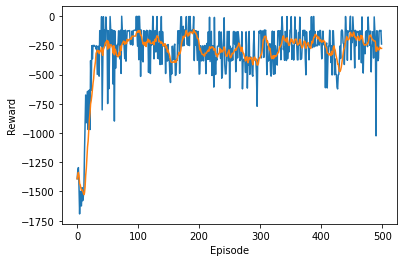

In [37]:

plt.plot( rewards     )
plt.plot( avg_rewards )
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

# Running the best model 

In [12]:
is_save_video = True

env   = gym.make( "Pendulum-v1" )  

# Set the random seeds
env.seed(              round( time.time( ) ) )
env.action_space.seed( round( time.time( ) ) )


# Get the dimension of states and actions, and also the 
# [WARNING] This is for environments where we assume the mean of action is 0. 
n_state    = env.observation_space.shape[ 0 ] 
n_action   = env.action_space.shape[ 0 ]
max_action = float( env.action_space.high  )

model_path = "../models/DDPG_best_model"
agent      = DDPGagent( n_state, n_action, max_action )
agent.load( model_path )

# Run trial
state = env.reset()   

frames = []
# The maximum trial is 200 for the pendulum 
for _ in range( 200 ):

    if is_save_video: frames.append( env.render( mode = "rgb_array")  ) 
    env.render( )

    # Get the choice of action and the pi( a_t | s_t ) for the gradient calculation
    action = agent.get_action( state )
    new_state, _, done, _ = env.step( action )

    # If the trail encounters the terminal state
    if done: 
        break
    state = new_state

# Save Video
env.close( )

if is_save_video:
    clip = mpy.ImageSequenceClip( frames, fps = 30 )
    clip.write_gif( "../videos/DDPG.gif" )

MoviePy - Building file ../videos/circle.gif with imageio.


t:  76%|███████▌  | 151/200 [00:04<00:01, 35.12it/s, now=None]